In [1]:
import os
import random
import numpy as np
from numpy import genfromtxt
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import sys
import shutil
import warnings

In [2]:
if 'google.colab' in str(get_ipython()):

  # To run in Gogogle Colab
  # You have to create a folder IFT6759 in your google drive 
  # and put all content of the folder ift-6759-forecast-project 

  #@title Mount your Google Drive

  %matplotlib inline
  %load_ext autoreload
  %autoreload 2

  from google.colab import drive
  #drive.mount('/content/gdrive')
  drive.mount("/content/gdrive", force_remount=True)

  folder = "/content/gdrive/MyDrive/IFT6759" #@param {type:"string"}
  !ln -Ts $folder /content/IFT6759 2> /dev/null

  # Add the assignment folder to Python path
  if '/content/IFT6759' not in sys.path:
      sys.path.insert(0, '/content/IFT6759')

  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/functions')
  import utils
  import load_creator
  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/models')
  import SUNSET
  import convGRU

else:

  import models.SUNSET as SUNSET
  import models.convGRU as convGRU
  import functions.utils as utils
  import functions.load_creator as load_creator

Mounted at /content/gdrive


In [3]:
# Create device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# set Random seed

seed = 10
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if device.type=='cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
# define folder location

dir_path = os.getcwd()

if 'google.colab' in str(get_ipython()):
  dir_path = os.path.join(dir_path, "gdrive/MyDrive/IFT6759")

data_folder = os.path.join(dir_path, "data")
model_folder = os.path.join(dir_path, "models")

#define file location

images_trainval_path = os.path.join(data_folder,'images_trainval.npy')
pv_log_trainval_path = os.path.join(data_folder,'pv_log_trainval.npy')
datetime_trainval_path = os.path.join(data_folder,'datetime_trainval.npy')

images_test_path = os.path.join(data_folder,'images_test.npy')
pv_log_test_path = os.path.join(data_folder,'pv_log_test.npy')
datetime_test_path = os.path.join(data_folder,'datetime_test.npy')

In [6]:
# load PV output and images for the trainval set

pv_log_trainval = np.load(pv_log_trainval_path)
images_trainval = np.load(images_trainval_path)
images_trainval = np.transpose(images_trainval, (0,3,1,2))
datetimes_trainval = np.load(datetime_trainval_path, allow_pickle=True)

# load PV output and images for the test set

pv_log_test = np.load(pv_log_test_path)
images_test = np.load(images_test_path)
images_test = np.transpose(images_test, (0,3,1,2))
datetimes_test = np.load(datetime_test_path, allow_pickle=True)# get weather classification

# train
w_class_train_path = os.path.join(data_folder,'train_label_3_classes_d.csv')
w_class_train = pd.read_csv(w_class_train_path)

index_train_sunny = np.where(w_class_train == 'Sunny')[0].tolist()
index_train_cloudy = np.where(w_class_train == 'Cloudy')[0].tolist()
index_train_overcast = np.where(w_class_train == 'Overcast')[0].tolist() 

#test
w_class_test_path = os.path.join(data_folder,'test_label_3_classes_d.csv')
w_class_test = pd.read_csv(w_class_test_path)

index_test_sunny = np.where(w_class_test == 'Sunny')[0].tolist()
index_test_cloudy = np.where(w_class_test == 'Cloudy')[0].tolist()
index_test_overcast = np.where(w_class_test == 'Overcast')[0].tolist()

In [7]:
np.shape(index_test_sunny), np.shape(index_test_cloudy), np.shape(index_test_overcast)

((5926,), (2941,), (1043,))

In [8]:
#Sunny

pv_log_trainval_sunny = pv_log_trainval[index_train_sunny] 
images_trainval_sunny = images_trainval[index_train_sunny]
datetimes_trainval_sunny = datetimes_trainval[index_train_sunny]

pv_log_test_sunny = pv_log_test[index_test_sunny]
images_test_sunny = images_test[index_test_sunny]
datetimes_test_sunny = datetimes_test[index_test_sunny]

# cloudy

pv_log_trainval_cloudy = pv_log_trainval[index_train_cloudy] 
images_trainval_cloudy = images_trainval[index_train_cloudy]
datetimes_trainval_cloudy = datetimes_trainval[index_train_cloudy]

pv_log_test_cloudy = pv_log_test[index_test_cloudy]
images_test_cloudy = images_test[index_test_cloudy]
datetimes_test_cloudy = datetimes_test[index_test_cloudy]

# overcast

pv_log_trainval_overcast = pv_log_trainval[index_train_overcast] 
images_trainval_overcast = images_trainval[index_train_overcast]
datetimes_trainval_overcast = datetimes_trainval[index_train_overcast]

pv_log_test_overcast = pv_log_test[index_test_overcast]
images_test_overcast = images_test[index_test_overcast]
datetimes_test_overcast = datetimes_test[index_test_overcast]

In [9]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [10]:
# seq_len, epochs, lr, weight_decay, conv_layers, convGRU_layers, fc_layers, name

epochs = 30

configs = {
  1:  (1, epochs, 3e-6, 1e-5, 2, 0, 2, 'Baseline 2-0-2'),
  2:  (1, epochs, 3e-6, 1e-5, 2, 0, 0, 'Sunny - 2-0-0'),
  3:  (1, epochs, 3e-6, 1e-5, 1, 1, 2, 'Overcast - 2-0-1'),
  4:  (2, epochs, 1e-5, 1e-5, 0, 2, 2, 'Seq 2 - 0-2-2'),
  5:  (3, epochs, 1e-5, 1e-5, 2, 1, 2, 'Seq 3 - 2-1-2'),  
  6:  (2, epochs, 1e-5, 1e-5, 0, 2, 0, 'Seq 2 - 0-2-0'),
  7:  (2, epochs, 1e-5, 1e-5, 0, 2, 1, 'Seq 2 - 0-2-1'),
  8:  (3, epochs, 1e-5, 1e-5, 0, 2, 0, 'Seq 3 - 0-2-0')
  }


# All data - SUNSET Architecture (Baseline)

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[1]

batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval, datetimes_test, images_trainval, images_test, 
                                                         pv_log_trainval, pv_log_test, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )


epoch: 0 train loss: 9.527039558276226 valid loss: 5.149295946720014 test loss: 5.636989591100189
epoch: 1 train loss: 4.1389714366593395 valid loss: 3.314970666407969 test loss: 3.7217499741103968
epoch: 2 train loss: 3.307299087834555 valid loss: 2.8585713508278965 test loss: 3.215322838546193
epoch: 3 train loss: 2.9823483476987174 valid loss: 2.635829243623302 test loss: 2.943353558024748
epoch: 4 train loss: 2.7901916269050253 valid loss: 2.5245899860529524 test loss: 2.7903217692528166
epoch: 5 train loss: 2.6728754893135855 valid loss: 2.400476366483284 test loss: 2.647169638030091
epoch: 6 train loss: 2.5847457732526657 valid loss: 2.340201236614939 test loss: 2.5942051029143056
epoch: 7 train loss: 2.5125772282433307 valid loss: 2.262886607778344 test loss: 2.5134369243654064
epoch: 8 train loss: 2.4519214364460593 valid loss: 2.2228790887734524 test loss: 2.4952171724963503
epoch: 9 train loss: 2.401906919069629 valid loss: 2.179887318577232 test loss: 2.46413447073143
epoch:

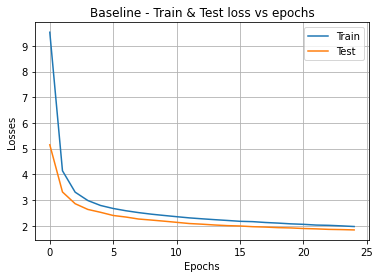

In [ ]:
x = np.arange(0, num_epochs)
plt.plot(x, Train_losses, label='Train')
plt.plot(x, Valid_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Baseline - Train & Test loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Sunny

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[2]

num_epochs = 80
learning_rate = 5e-6
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )

epoch: 0 train loss: 15.509173258759798 valid loss: 11.928188126625617 test loss: 11.911992242681578
epoch: 1 train loss: 9.6571982782524 valid loss: 7.842347042120504 test loss: 7.936710553290767
epoch: 2 train loss: 6.898240125804945 valid loss: 6.227329359296708 test loss: 6.339750158111805
epoch: 3 train loss: 5.754501911779981 valid loss: 5.375483772339673 test loss: 5.491316496248786
epoch: 4 train loss: 4.990903665542706 valid loss: 4.678557191285605 test loss: 4.785169375144733
epoch: 5 train loss: 4.354757366905427 valid loss: 4.10141840768211 test loss: 4.185116184195902
epoch: 6 train loss: 3.8350215272665693 valid loss: 3.616541828510738 test loss: 3.6686561589177136
epoch: 7 train loss: 3.430919939565442 valid loss: 3.2743837615458813 test loss: 3.294220842684798
epoch: 8 train loss: 3.1333612532972124 valid loss: 3.0111466579446686 test loss: 3.001610829073075
epoch: 9 train loss: 2.9202034863421167 valid loss: 2.8326882736451258 test loss: 2.804111065973835
epoch: 10 tra

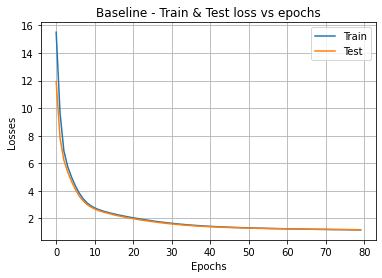

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[2]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_loss = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 12.704080549053822 valid loss: 7.7068322279283645 test loss: 7.53320445441139
epoch: 1 train loss: 6.314228050694104 valid loss: 5.258830566178914 test loss: 5.2262376371299935
epoch: 2 train loss: 4.573835431665012 valid loss: 4.015808468238275 test loss: 4.0438770850097985
epoch: 3 train loss: 3.6184992882414235 valid loss: 3.3306896945447315 test loss: 3.356098555234778
epoch: 4 train loss: 3.111871568707952 valid loss: 2.9601321608416082 test loss: 2.96122343207417
epoch: 5 train loss: 2.8431065608985326 valid loss: 2.764861906589812 test loss: 2.758648158203598
epoch: 6 train loss: 2.670722587529544 valid loss: 2.614893026795985 test loss: 2.5983827447130667
epoch: 7 train loss: 2.533299443992104 valid loss: 2.4869158333105674 test loss: 2.4627279687065844
epoch: 8 train loss: 2.4141515763239823 valid loss: 2.370924494035586 test loss: 2.3522785745537536
epoch: 9 train loss: 2.3093267863617863 valid loss: 2.270368833024781 test loss: 2.244630671297848
epoch: 1

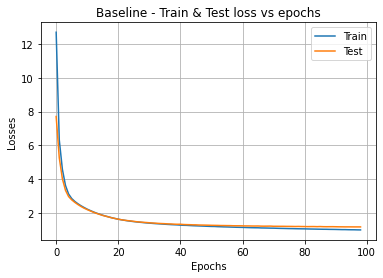

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Cloudy

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[2]

num_epochs = 100
learning_rate = 5e-6
batch_size = 256
batch_size_eval = 256

#model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
model = SUNSET.SUNSET_Cloudy().to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_loss = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 14.003130127583377 valid loss: 12.400249945522242 test loss: 13.467033279840544
epoch: 1 train loss: 11.316606048428275 valid loss: 10.086555032558474 test loss: 11.399977331470842
epoch: 2 train loss: 9.364457443042289 valid loss: 8.532249966145883 test loss: 9.969823842603347
epoch: 3 train loss: 8.08732699953476 valid loss: 7.549794669697004 test loss: 9.01399737177342
epoch: 4 train loss: 7.280200729476392 valid loss: 6.894147798667382 test loss: 8.3348614684204
epoch: 5 train loss: 6.71997955494522 valid loss: 6.402011640990854 test loss: 7.801314653105936
epoch: 6 train loss: 6.280086011574159 valid loss: 6.027080003885644 test loss: 7.395478823902569
epoch: 7 train loss: 5.911831531717987 valid loss: 5.683092506424431 test loss: 7.018999697664251
epoch: 8 train loss: 5.594318391783593 valid loss: 5.39351166273552 test loss: 6.6954092804117336
epoch: 9 train loss: 5.3199890963767835 valid loss: 5.151602541685831 test loss: 6.415992378169274
epoch: 10 train lo

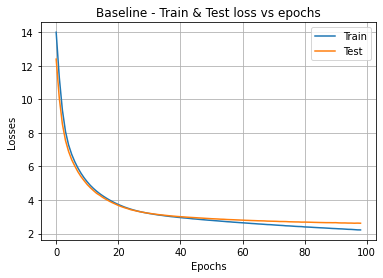

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[2]

num_epochs = 100
learning_rate = 3e-6
batch_size = 256
batch_size_eval = 256

#model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
model = SUNSET.SUNSET_Cloudy().to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )

epoch: 0 train loss: 14.926688425849466 valid loss: 13.91904506307281 test loss: 14.658504700271859
epoch: 1 train loss: 13.126175332895286 valid loss: 12.215599122495137 test loss: 13.135015004859971
epoch: 2 train loss: 11.509099418696165 valid loss: 10.721569993890519 test loss: 11.806151721894608
epoch: 3 train loss: 10.123799281726939 valid loss: 9.48245523000705 test loss: 10.685629693293135
epoch: 4 train loss: 8.9943899270637 valid loss: 8.52067287735488 test loss: 9.796611231168274
epoch: 5 train loss: 8.116911577369697 valid loss: 7.74027878604136 test loss: 9.06167669721303
epoch: 6 train loss: 7.460329004722401 valid loss: 7.197689733185328 test loss: 8.5344001300785
epoch: 7 train loss: 6.97106094871051 valid loss: 6.7858638021140605 test loss: 8.125012691121542
epoch: 8 train loss: 6.603702139363966 valid loss: 6.465774144739269 test loss: 7.800407711228991
epoch: 9 train loss: 6.314280344101481 valid loss: 6.2056379346415484 test loss: 7.5298762372716554
epoch: 10 train 

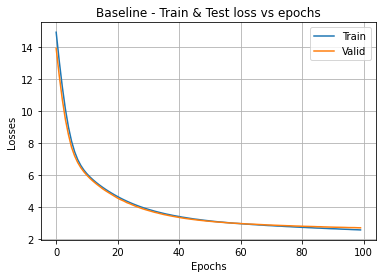

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Overcast

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[3]

num_epochs = 50
learning_rate = 8e-6
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_loss = sum(Test_epoch_losses)/len(Test_epoch_losses)

epoch: 0 train loss: 5.67364338490931 valid loss: 4.669609720838363 test loss: 3.4709638323387404
epoch: 1 train loss: 4.142983540130303 valid loss: 3.464173772287582 test loss: 2.948812297314524
epoch: 2 train loss: 3.5419454070925958 valid loss: 3.4441578707869236 test loss: 3.22625629985948
epoch: 3 train loss: 3.4731509691087528 valid loss: 3.3781083256090954 test loss: 2.9818290419538194
epoch: 4 train loss: 3.4277626363202947 valid loss: 3.338550220458622 test loss: 3.0288133522344842
epoch: 5 train loss: 3.3837662004434814 valid loss: 3.2937975018277372 test loss: 2.9854016835365864
epoch: 6 train loss: 3.340170451360195 valid loss: 3.244119350960919 test loss: 2.921230432832211
epoch: 7 train loss: 3.3085482601632483 valid loss: 3.1913168373380665 test loss: 2.9171252622201425
epoch: 8 train loss: 3.2332882788732196 valid loss: 3.129833977669634 test loss: 2.8615825622805353
epoch: 9 train loss: 3.179163340198321 valid loss: 3.0617911347689275 test loss: 2.8043037325690894
epoc

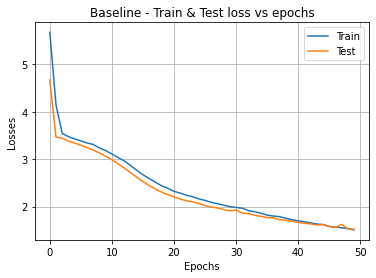

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[3]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_loss = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 5.5924436630447065 valid loss: 4.43420311468607 test loss: 3.276224936208405
epoch: 1 train loss: 3.9210903763834377 valid loss: 3.52795662916482 test loss: 3.249247870660434
epoch: 2 train loss: 3.53569546428833 valid loss: 3.4319838752533975 test loss: 3.065559162898066
epoch: 3 train loss: 3.4397813159866972 valid loss: 3.3588287825578482 test loss: 2.9767121441672018
epoch: 4 train loss: 3.3561311541466847 valid loss: 3.2827702022511978 test loss: 2.946669677311235
epoch: 5 train loss: 3.269477719975321 valid loss: 3.1991996295302814 test loss: 2.894869333093674
epoch: 6 train loss: 3.1811613996334485 valid loss: 3.1049811372505323 test loss: 2.792671205854422
epoch: 7 train loss: 3.083282588450306 valid loss: 3.0032788419096517 test loss: 2.7114337027819344
epoch: 8 train loss: 2.977879812684145 valid loss: 2.896380572990829 test loss: 2.680770607196944
epoch: 9 train loss: 2.865754510583248 valid loss: 2.7786383082069888 test loss: 2.547211063996647
epoch: 10

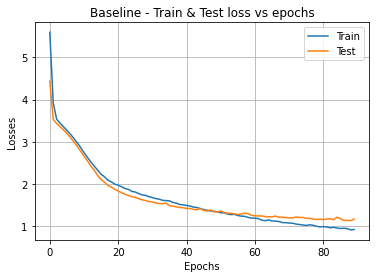

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Overall Class Prediction

In [ ]:
overall_loss = len(images_test_sunny)*sunny_loss**2 + len(images_test_cloudy)*cloudy_loss**2 + len(images_test_overcast)*overcast_loss**2
overall_loss = overall_loss / (len(images_test_overcast) + len(images_test_sunny) + len(images_test_cloudy))
overall_loss = math.sqrt(overall_loss)
overall_loss

2.310958105830714

# All data - ConvGRU

In [21]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[4]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval, datetimes_test, images_trainval, images_test, 
                                                         pv_log_trainval, pv_log_test, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 6.217737448204294 valid loss: 3.301277614472515 test loss: 3.810265932128868
epoch: 1 train loss: 3.217136290227682 valid loss: 2.635552773137079 test loss: 3.026596374564674
epoch: 2 train loss: 2.837339788447406 valid loss: 2.4093853172115582 test loss: 2.7497526766200626
epoch: 3 train loss: 2.634240004364168 valid loss: 2.256783455308852 test loss: 2.5558770690316677
epoch: 4 train loss: 2.500355169993009 valid loss: 2.2253801700298332 test loss: 2.5337344755949744
epoch: 5 train loss: 2.4059726152761205 valid loss: 2.1401780952730998 test loss: 2.4844481350164993
epoch: 6 train loss: 2.3515795873488092 valid loss: 2.0374829991900114 test loss: 2.399937111229563
epoch: 7 train loss: 2.2935312020012857 valid loss: 2.0177367312659875 test loss: 2.402391955224947
epoch: 8 train loss: 2.2387547552656777 valid loss: 1.9792404999551119 test loss: 2.348852377100266
epoch: 9 train loss: 2.2088560354872238 valid loss: 1.94607809202262 test loss: 2.332137194259546
epoch:

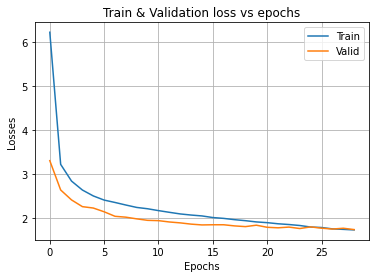

In [22]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Sunny - ConvGRU

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[4]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))



epoch: 0 train loss: 7.162054391763511 valid loss: 3.5327797292216 test loss: 3.6886329298313596
epoch: 1 train loss: 3.0535116572108723 valid loss: 2.2274820411444187 test loss: 2.2610667731293375
epoch: 2 train loss: 2.3842268883537843 valid loss: 1.8097933892225178 test loss: 1.7787792920771408
epoch: 3 train loss: 2.137057931869082 valid loss: 1.6172069828548288 test loss: 1.6303156731160722
epoch: 4 train loss: 1.9969177580517408 valid loss: 1.5113491121968696 test loss: 1.5246924562883104
epoch: 5 train loss: 1.9108326192417282 valid loss: 1.4490043267742998 test loss: 1.4617775523173702
epoch: 6 train loss: 1.8217955093318696 valid loss: 1.4193709876218397 test loss: 1.4420674124545636
epoch: 7 train loss: 1.7755825049592806 valid loss: 1.3429995061929982 test loss: 1.381927918201813
epoch: 8 train loss: 1.7295148632049193 valid loss: 1.3283534544506455 test loss: 1.3771286695520784
epoch: 9 train loss: 1.6935140391306842 valid loss: 1.2781219346609032 test loss: 1.3786131454448

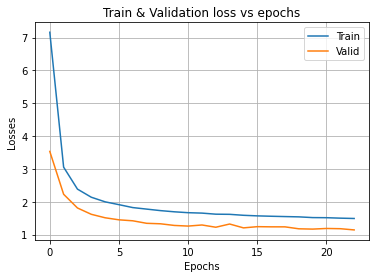

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[5]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c5 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 10.31018670447419 valid loss: 4.101713528280083 test loss: 4.198164953121366
epoch: 1 train loss: 3.2850528999133477 valid loss: 2.7566375218899646 test loss: 2.7432455992915337
epoch: 2 train loss: 2.657668469044828 valid loss: 2.2670257726414396 test loss: 2.2864194785625926
epoch: 3 train loss: 2.2994454349450693 valid loss: 1.9227749219115287 test loss: 1.9318813968090676
epoch: 4 train loss: 2.0673425457854493 valid loss: 1.7069130677412818 test loss: 1.7275256005752293
epoch: 5 train loss: 1.9143302901214374 valid loss: 1.5586360875981724 test loss: 1.5850663392981885
epoch: 6 train loss: 1.8043986603454427 valid loss: 1.4584657914461314 test loss: 1.480019128665575
epoch: 7 train loss: 1.7397972925987988 valid loss: 1.3863593068401268 test loss: 1.4018753346544848
epoch: 8 train loss: 1.6922482463201234 valid loss: 1.3466386320501944 test loss: 1.3704918137181972
epoch: 9 train loss: 1.6484016740099345 valid loss: 1.3271361929903844 test loss: 1.340284820419

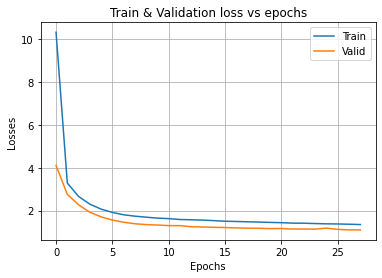

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [15]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[6]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c6 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 8.93787948340384 valid loss: 5.735890336177441 test loss: 5.742230018177463
epoch: 1 train loss: 5.289042907187393 valid loss: 4.632052641231096 test loss: 4.712300630818312
epoch: 2 train loss: 3.947963665380598 valid loss: 3.2405882292159505 test loss: 3.3395725752697367
epoch: 3 train loss: 2.9194270393879997 valid loss: 2.6721342377565542 test loss: 2.6706684731210784
epoch: 4 train loss: 2.5565369507265414 valid loss: 2.4504920360673883 test loss: 2.3845100284264364
epoch: 5 train loss: 2.3693675586028933 valid loss: 2.295555975521443 test loss: 2.220591533775337
epoch: 6 train loss: 2.2267556005835263 valid loss: 2.1661219302444734 test loss: 2.08713615496063
epoch: 7 train loss: 2.1027538162169015 valid loss: 2.0567277173504483 test loss: 1.960216478780984
epoch: 8 train loss: 1.996151156411148 valid loss: 1.9514350055899652 test loss: 1.8787451177136594
epoch: 9 train loss: 1.9000406683319675 valid loss: 1.863490703996525 test loss: 1.795663110202232
epoch:

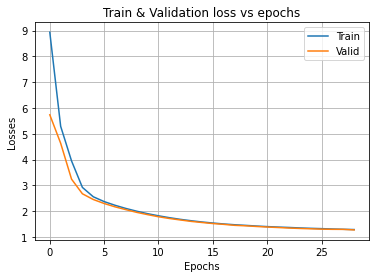

In [16]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[7]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c7 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 9.186557972984694 valid loss: 5.343100214334482 test loss: 5.360213185428533
epoch: 1 train loss: 4.57859485613395 valid loss: 3.1568568983015375 test loss: 3.17377025049458
epoch: 2 train loss: 2.95712370162414 valid loss: 2.4163958984022433 test loss: 2.3801227863417393
epoch: 3 train loss: 2.565673927728403 valid loss: 2.131588856404446 test loss: 2.1121739277063925
epoch: 4 train loss: 2.3446825387565817 valid loss: 1.9201463715238356 test loss: 1.9406534488215375
epoch: 5 train loss: 2.181469689104567 valid loss: 1.7677246093011383 test loss: 1.7755805626064747
epoch: 6 train loss: 2.0625279455262437 valid loss: 1.6554718749305464 test loss: 1.6680814347460085
epoch: 7 train loss: 1.966809584205069 valid loss: 1.5687668269356894 test loss: 1.5815454203471302
epoch: 8 train loss: 1.9029725279598413 valid loss: 1.523273723493138 test loss: 1.5276394168996417
epoch: 9 train loss: 1.8398173297887093 valid loss: 1.4389944881853234 test loss: 1.4848458047261508
epoc

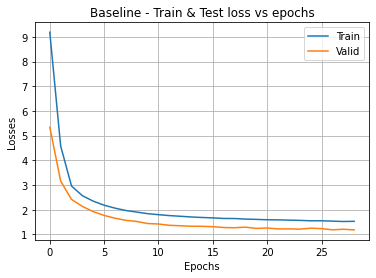

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[8]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_GRU_loss_c8 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 8.287052895925006 valid loss: 5.371589265917695 test loss: 5.388786916343876
epoch: 1 train loss: 4.896185186135051 valid loss: 4.310077562820841 test loss: 4.389148921612065
epoch: 2 train loss: 3.8467006175302965 valid loss: 3.305054406680732 test loss: 3.4030336837671404
epoch: 3 train loss: 3.0408795242987963 valid loss: 2.731033767470391 test loss: 2.774229374893548
epoch: 4 train loss: 2.6257781262047044 valid loss: 2.4437628660460016 test loss: 2.4386708098909993
epoch: 5 train loss: 2.3759862355239196 valid loss: 2.234058956990292 test loss: 2.2287577027275534
epoch: 6 train loss: 2.1789380138963725 valid loss: 2.055128137413205 test loss: 2.11585669546201
epoch: 7 train loss: 2.0140758773124956 valid loss: 1.9008250951625068 test loss: 1.9562751540394605
epoch: 8 train loss: 1.8785178630493853 valid loss: 1.7811509890360153 test loss: 1.86311857856875
epoch: 9 train loss: 1.7690952754770128 valid loss: 1.6846275939660915 test loss: 1.7865362857644191
epoch

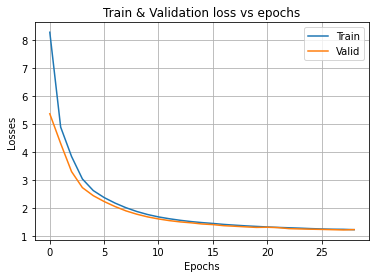

In [18]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Cloudy - ConvGRU

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[4]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 8.740792379325137 valid loss: 6.61511922498495 test loss: 7.178934529635244
epoch: 1 train loss: 6.132892952400634 valid loss: 5.266228312876442 test loss: 6.252248615573324
epoch: 2 train loss: 4.982140229600949 valid loss: 4.414113668116492 test loss: 5.371563949335745
epoch: 3 train loss: 4.391738305446092 valid loss: 3.9501343036558314 test loss: 4.875983679480371
epoch: 4 train loss: 4.045971272658999 valid loss: 3.7050186850507365 test loss: 4.465614284786458
epoch: 5 train loss: 3.8377062753416675 valid loss: 3.5306873062806896 test loss: 4.251488793258108
epoch: 6 train loss: 3.6702725534740233 valid loss: 3.3902883664755903 test loss: 4.091133331470567
epoch: 7 train loss: 3.554336369314264 valid loss: 3.32161137980607 test loss: 3.9350228348410465
epoch: 8 train loss: 3.466156498627634 valid loss: 3.232322873199406 test loss: 3.8806269677940826
epoch: 9 train loss: 3.379986961197427 valid loss: 3.2172744247245006 test loss: 3.7979905539451173
epoch: 10 tr

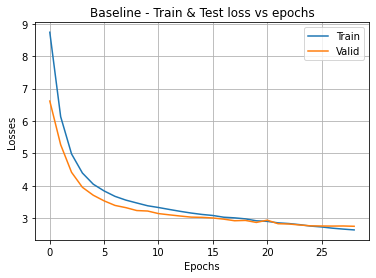

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[5]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c5 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 11.901181467566555 valid loss: 7.106224394386014 test loss: 7.836093098391562
epoch: 1 train loss: 6.451856893531573 valid loss: 5.688186400285426 test loss: 6.8889818822570685
epoch: 2 train loss: 5.311869944315861 valid loss: 4.81902064030666 test loss: 5.983276005057686
epoch: 3 train loss: 4.656852201460346 valid loss: 4.293399885927754 test loss: 5.27179526270409
epoch: 4 train loss: 4.230777441709727 valid loss: 3.919631078554226 test loss: 4.764314704948043
epoch: 5 train loss: 3.89562998244646 valid loss: 3.6202637944624136 test loss: 4.298539749405575
epoch: 6 train loss: 3.6347841695090093 valid loss: 3.4146273275850434 test loss: 3.9360371067065563
epoch: 7 train loss: 3.444327969770902 valid loss: 3.289734709416389 test loss: 3.7540749564948497
epoch: 8 train loss: 3.317880538471383 valid loss: 3.187866271203668 test loss: 3.736433402874747
epoch: 9 train loss: 3.22934321746745 valid loss: 3.1336994854100655 test loss: 3.6599593441263893
epoch: 10 train

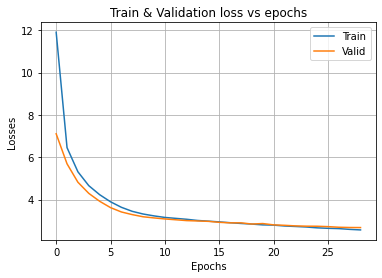

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[6]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c6 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 9.725625687754063 valid loss: 7.242064780514177 test loss: 7.491108775578108
epoch: 1 train loss: 6.956858403599148 valid loss: 6.828412970375299 test loss: 7.310622042165581
epoch: 2 train loss: 6.482392938988597 valid loss: 6.250735323197317 test loss: 7.020443533897134
epoch: 3 train loss: 5.896757454399202 valid loss: 5.662303985298618 test loss: 6.716484853747415
epoch: 4 train loss: 5.408470221838279 valid loss: 5.238952576752556 test loss: 6.391896377421656
epoch: 5 train loss: 5.079476044845034 valid loss: 4.947269713387425 test loss: 6.081840176741919
epoch: 6 train loss: 4.845931134120767 valid loss: 4.727696793341924 test loss: 5.776242601671916
epoch: 7 train loss: 4.654484415201887 valid loss: 4.541952410566256 test loss: 5.536364294652452
epoch: 8 train loss: 4.511928932335891 valid loss: 4.399780277095409 test loss: 5.3256718781218435
epoch: 9 train loss: 4.394032218283996 valid loss: 4.27677401040878 test loss: 5.18045841134641
epoch: 10 train loss:

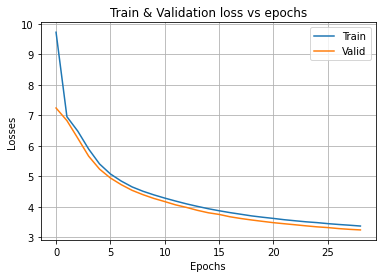

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[7]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c7 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 7.265977837848892 valid loss: 5.500904762819586 test loss: 6.422703383433527
epoch: 1 train loss: 4.986392856714747 valid loss: 4.529264452886262 test loss: 5.561964544529352
epoch: 2 train loss: 4.3716167679281295 valid loss: 4.104685828906429 test loss: 5.044581500142919
epoch: 3 train loss: 4.0178042457759355 valid loss: 3.8264846578919274 test loss: 4.58934266935129
epoch: 4 train loss: 3.774861612064543 valid loss: 3.6139739918335008 test loss: 4.325678547081538
epoch: 5 train loss: 3.6062043344704904 valid loss: 3.4684986196149796 test loss: 4.149612373078153
epoch: 6 train loss: 3.485477841207936 valid loss: 3.415560323645452 test loss: 4.033195106186131
epoch: 7 train loss: 3.4080851214708114 valid loss: 3.2898467279268524 test loss: 3.929284402498233
epoch: 8 train loss: 3.3162661206161905 valid loss: 3.2208167486258623 test loss: 3.8980080089244344
epoch: 9 train loss: 3.265837448176926 valid loss: 3.1813996791149455 test loss: 3.8454431944169567
epoch: 1

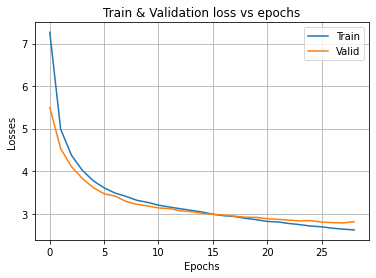

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[8]

num_epochs = 30
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_GRU_loss_c8 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 9.625808595937773 valid loss: 7.1206828771974005 test loss: 7.516624427656092
epoch: 1 train loss: 6.953609929412237 valid loss: 6.727013151399259 test loss: 7.289238658824502
epoch: 2 train loss: 6.517659097198348 valid loss: 6.253889086606019 test loss: 7.0327929955974975
epoch: 3 train loss: 6.0154451110033005 valid loss: 5.737176967031697 test loss: 6.660340275597537
epoch: 4 train loss: 5.526416980076504 valid loss: 5.275237270364454 test loss: 6.294677769898946
epoch: 5 train loss: 5.112740546124648 valid loss: 4.940249232157666 test loss: 6.003111024915705
epoch: 6 train loss: 4.809419785511802 valid loss: 4.6676087871460785 test loss: 5.657291704690718
epoch: 7 train loss: 4.579223626537821 valid loss: 4.447215748481184 test loss: 5.400396447430912
epoch: 8 train loss: 4.397647834011669 valid loss: 4.303846840031147 test loss: 5.228323042162348
epoch: 9 train loss: 4.274462629562671 valid loss: 4.202812493817301 test loss: 5.061032340234704
epoch: 10 train 

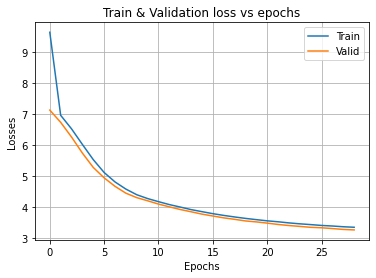

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Overcast - ConvGRU

In [ ]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[4]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c4 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 4.464689647491816 valid loss: 3.585965512828041 test loss: 3.9339674820202637
epoch: 1 train loss: 3.5552973900746334 valid loss: 3.23782477900813 test loss: 3.0276196488639155
epoch: 2 train loss: 3.456519310576373 valid loss: 3.194896672654138 test loss: 3.1120751937855484
epoch: 3 train loss: 3.4223975773605146 valid loss: 3.141490345000328 test loss: 3.076564944056006
epoch: 4 train loss: 3.3533615052122787 valid loss: 3.0786366587432994 test loss: 3.0204242426949803
epoch: 5 train loss: 3.289328868523953 valid loss: 3.021277645466195 test loss: 3.0621645756647387
epoch: 6 train loss: 3.210094637143393 valid loss: 2.932726938089362 test loss: 2.948525114156598
epoch: 7 train loss: 3.128461495191887 valid loss: 2.8879950299749257 test loss: 3.0380306031868973
epoch: 8 train loss: 3.036314874118229 valid loss: 2.7692354137448496 test loss: 2.875563001538031
epoch: 9 train loss: 2.9534565556985273 valid loss: 2.667421634280939 test loss: 2.7011845816730418
epoch: 

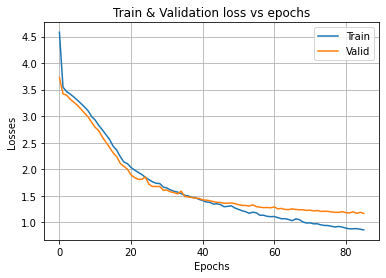

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[5]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c5 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 5.744497856225667 valid loss: 5.2905124491051465 test loss: 3.9320854125962303
epoch: 1 train loss: 4.412393764840913 valid loss: 3.710003372255278 test loss: 2.7930729101701637
epoch: 2 train loss: 3.4692973242135814 valid loss: 3.459502912376287 test loss: 3.1456678811991305
epoch: 3 train loss: 3.39059857269197 valid loss: 3.3742182725635246 test loss: 2.853837502308348
epoch: 4 train loss: 3.3104016090014943 valid loss: 3.295499320470875 test loss: 2.8487335593584397
epoch: 5 train loss: 3.2395488707664026 valid loss: 3.216195409806308 test loss: 2.7822863005614056
epoch: 6 train loss: 3.1543127554729633 valid loss: 3.1220452777508956 test loss: 2.7476668714547383
epoch: 7 train loss: 3.0677947958654768 valid loss: 3.0284195888163565 test loss: 2.6348724405939588
epoch: 8 train loss: 2.9606461146906025 valid loss: 2.9228246543149963 test loss: 2.5836501044276035
epoch: 9 train loss: 2.869137416951848 valid loss: 2.8103967545456214 test loss: 2.55732395969434
ep

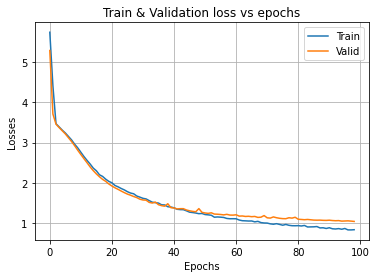

In [12]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[6]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c6 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 5.088033511915265 valid loss: 3.97826710504054 test loss: 2.8549249799310963
epoch: 1 train loss: 3.4785759637452354 valid loss: 3.598161255643699 test loss: 3.3572750003340053
epoch: 2 train loss: 3.4247609516885023 valid loss: 3.5554195165652924 test loss: 3.0658785951199254
epoch: 3 train loss: 3.3854080681378442 valid loss: 3.5412502330975775 test loss: 3.0481420860204196
epoch: 4 train loss: 3.369457730185027 valid loss: 3.52294035648939 test loss: 3.0737671320994187
epoch: 5 train loss: 3.352909071246185 valid loss: 3.5068496433771483 test loss: 3.053518694623347
epoch: 6 train loss: 3.335725615630445 valid loss: 3.4898278566251943 test loss: 3.032926056152559
epoch: 7 train loss: 3.316735315994313 valid loss: 3.4699681697117293 test loss: 3.042652530903001
epoch: 8 train loss: 3.2981138414118396 valid loss: 3.452231703008595 test loss: 3.0019554762642406
epoch: 9 train loss: 3.278137048016758 valid loss: 3.4295783611181117 test loss: 3.013801675795617
epoch:

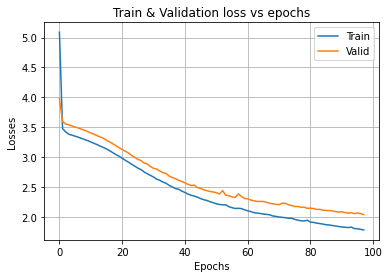

In [14]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [15]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[7]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c7 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 3.968422569809372 valid loss: 3.6898218385677795 test loss: 2.814411329617089
epoch: 1 train loss: 3.405558994605591 valid loss: 3.436408917325078 test loss: 2.919615952135545
epoch: 2 train loss: 3.2951427816223635 valid loss: 3.341105171260552 test loss: 2.9032118577616104
epoch: 3 train loss: 3.20555665958353 valid loss: 3.234624598443855 test loss: 2.9513841553633795
epoch: 4 train loss: 3.1239845351622204 valid loss: 3.1433791732815757 test loss: 2.921834179241474
epoch: 5 train loss: 3.044173940259952 valid loss: 3.0587845191321907 test loss: 2.8499313790202443
epoch: 6 train loss: 2.974248767795663 valid loss: 2.977272507915714 test loss: 2.789126293158648
epoch: 7 train loss: 2.9083788848271204 valid loss: 2.8996170295980717 test loss: 2.81818405658547
epoch: 8 train loss: 2.835723822709264 valid loss: 2.827712877235226 test loss: 2.72104310963795
epoch: 9 train loss: 2.769104713210701 valid loss: 2.754972232869532 test loss: 2.691643931265006
epoch: 10 tra

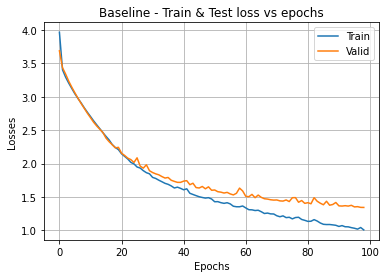

In [16]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Baseline - Train & Test loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
seq_len, num_epochs, learning_rate, weight_decay, conv_layers, convGRU_layers, fc_layers, title = configs[8]

num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_GRU4(conv_layers=conv_layers, convGRU_layers = convGRU_layers, fc_layers = fc_layers ).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_gru(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_gru(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_gru(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_GRU_loss_c8 = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 4.93961950045319 valid loss: 3.633988774882638 test loss: 2.8404427975222033
epoch: 1 train loss: 3.5084640650359646 valid loss: 3.4427631443070665 test loss: 3.3918826410244174
epoch: 2 train loss: 3.4540370150133484 valid loss: 3.3758657628324924 test loss: 3.029715104344906
epoch: 3 train loss: 3.4185581142184116 valid loss: 3.3491863710785075 test loss: 3.073712047960092
epoch: 4 train loss: 3.3909033154656645 valid loss: 3.325333596141333 test loss: 3.054735316748501
epoch: 5 train loss: 3.3631085861994037 valid loss: 3.299798824645846 test loss: 3.0220724668086847
epoch: 6 train loss: 3.33475559627453 valid loss: 3.272429948400457 test loss: 3.0406217553036323
epoch: 7 train loss: 3.3050256965371942 valid loss: 3.2443659292232896 test loss: 2.9897405540679243
epoch: 8 train loss: 3.2733602556920243 valid loss: 3.215605326645111 test loss: 2.9943191669140155
epoch: 9 train loss: 3.242091756519525 valid loss: 3.186932316981508 test loss: 2.957104608152468
epoch

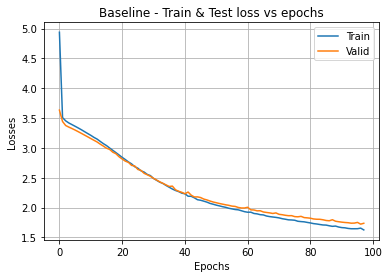

In [18]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Baseline - Train & Test loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Overall GRU

In [19]:
overcast_GRU_loss_c4 = 1.7243181806093018
cloudy_GRU_loss_c4 = 3.5056907896302443
sunny_GRU_loss_c4 = 1.3049186376409114

In [20]:
overall_loss = len(images_test_sunny)*sunny_GRU_loss_c4**2 + len(images_test_cloudy)*cloudy_GRU_loss_c4**2 + len(images_test_overcast)*overcast_GRU_loss_c4**2
overall_loss = overall_loss / (len(images_test_overcast) + len(images_test_sunny) + len(images_test_cloudy))
overall_loss = math.sqrt(overall_loss)
overall_loss

2.2312452626893564